# Fig 4: High-level analysis of GP output

This notebook is used to analyze the Gaussian process output from the file `gp_pipeline.jl`
including the MSD analysis

# Setup and load data

In [212]:
using CSV
using DataFrames
using Distributions
using StatsBase
using PythonPlot
using Random
using Tables
using DifferentialEquations
include("./../src/GrowthTraceTools.jl")
using .GrowthTraceTools
cd(dirname(@__FILE__))

## Load experimental data

In [213]:
# raw data
data_raw = CSV.read("./../src/output/data_processed.csv",DataFrames.DataFrame);
lineages = unique(df_raw.lineage);

In [216]:
pred_dir = "./../src/output/output_8-29-24"
data_gp = CSV.read(pred_dir*"/preds.csv",DataFrame);
lineages = unique(pred_df.lineage);
lineages

7-element Vector{Float64}:
  1.0
  2.0
  4.0
  5.0
  6.0
 14.0
 22.0

# High-level visualization of output

## Consistency with raw data

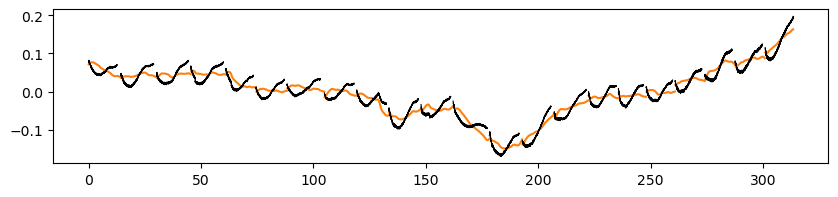

In [215]:
fig,ax = subplots(figsize=(10,2))
k = 4

dr = data_raw[df_raw.lineage .== lineages[k],:]
dr = dr[dr.cellcycle .== "i",:]
dr.time = dr.time .- dr.time[1]
y = dr.lnM_sum 
t = dr.time
dr[:,:z] = y .- cov(y,t)/var(t) .*t
dr[:,:z] = dr.z .- mean(dr.z)

pred = data_gp[data_gp.lineage .== lineages[k],:]
#ax.plot(preds[k].time,preds[k].matern32_flucs_x)
for p in unique(pred.position)
    d = pred[pred.position .==p,:]
    #ax.plot(d.time,d.matern32_cell_x,"C0-")
    ax.plot(d.time,d.matern32_flucs,"C1-")
    d = dr[dr.position .==p,:]
    ax.plot(d.time,d.z,"k-",lw=0.8)

end
fig

## Relative size of terms in decomposition

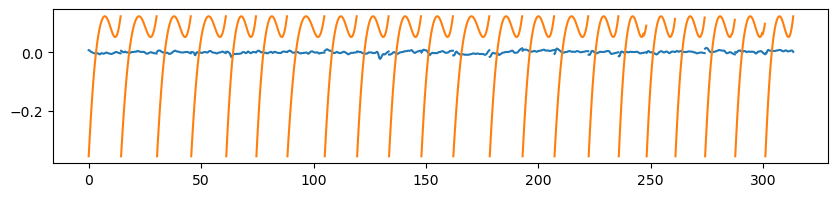

In [152]:
fig,ax = subplots(figsize=(10,2))
#ax.plot(preds[k].time,preds[k].matern32_flucs_x)
for p in unique(pred.position)
    d = pred
    ax.plot(d[d.position .== p,:].time,d[d.position .== p,:].matern32_flucs_x,"C0-")
    ax.plot(d[d.position .== p,:].time,d[d.position .== p,:].matern32_cell_x ,"C1-")
end
fig

# Characterization of fluctuations

## Cell-cycle trend (D)

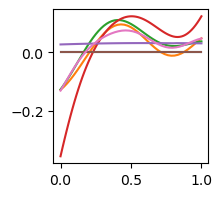

In [153]:


fig, ax= subplots(figsize=(2,2))
for lin in lineages
    pred = data_gp[data_gp.lineage .== lin,:]
    pred = pred[pred.position .==1,:]
    an = pred.time .- pred.time[1]
    an = an ./ an[end]
    ax.plot(an,pred.matern32_cell_x)
end
fig

## Autocorrelations (E)

## Variance vs. cell-cycle (F)

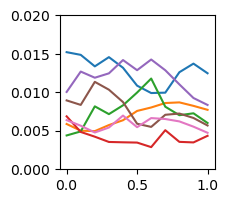

In [154]:


fig, ax= subplots(figsize=(2,2))
for lin in lineages
    pred = data_gp[data_gp.lineage .== lin,:]
    if length(unique(pred.position))>6
        pred = combine(groupby(pred,:position),:time => (x -> x .- x[1]) => :age,:time => (x -> (x .- x[1]) ./ (x[end] - x[1])) => :age_normed,names(pred))
        pred[:,:age_normed] = round.(pred.age_normed,digits=1)
        vdf = combine(groupby(pred,:age_normed),:matern32_flucs_x => std => :v)
        sort!(vdf,:age_normed)
        ax.plot(vdf.age_normed,vdf.v,"-")
    end
end
ax.set_ylim([0,0.02])
fig


# Prediction of variance of cell-cycle averaged growth

## Setup

In [155]:
data_cells = combine(groupby(data_gp,[:lineage,:position]),
    :matern32_flucs_x=>mean=>:gr,
    :time=>(x->x[end]-x[1])=>:gt);

# get time interval for predicted arrays
dt = mean(diff(data_gp[data_gp.lineage .== lineages[1],:time])); 

In [156]:
function fit_ar(df)
    t = df[:,:time]
    dt = mean(diff(t))
    x = df[1:1:end,:matern32_flucs_x]
    X = hcat(ones(length(x)-1),x[1:end-1])
    y = x[2:end]
    b = X\y
    v = mean((X*b .- y) .^2)

    τ =  dt/(1-b[2])
    D = v/2/dt
    θ = (Δ = 60.0,σDN = 0.0,τ = τ,D = D,λ0 = 0.07,σM = sqrt(30.0))
    return θ
end



fit_ar (generic function with 1 method)

## Fitting and simulations

In [158]:
nreps = 50
sims_cells = []
for lin in lineages
    # -----------------------------------------------------------
    df = data_gp[data_gp.lineage .==lin,:]
    θ = fit_ar(df)
    init = [θ.Δ,θ.λ0,2*θ.Δ,0]

    for i in 1:nreps
        # build model and run 
        prob,callback,names = GrowthTraceTools.build_model_OU(θ,init,df.time)
        sol = solve(prob,callback = callback);
        println(length(unique(df.position)))

        # -----------------------------------------------------------
        # put in dataframe 
        sim = GrowthTraceTools.solver_output_to_dataframe(sol,names)
        sim = sim[sim.position .< max(sim.position...),:]
        df_cells = combine(groupby(sim,:position),:λ=>mean=>:gr,:time=>(x->x[end]-x[1])=>:gt)
        #df_cells[df_cells.gt .> 0,:];
        df_cells[:,:lineage] = ones(length(df_cells.gr)) .* lin
        df_cells[:,:replicate] = ones(length(df_cells.gr)) .* i
        push!(sims_cells,df_cells)
    end
end
sims_cells = vcat(sims_cells...);

12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
1

In [165]:
sims_cells

Row,position,gr,gt,lineage,replicate
,Float64,Float64,Float64,Float64,Float64
1,0.0,0.0686919,10.0997,1.0,1.0
2,1.0,0.061551,11.7318,1.0,1.0
3,2.0,0.0793208,8.8318,1.0,1.0
4,3.0,0.0777452,7.881,1.0,1.0
5,4.0,0.074379,9.46343,1.0,1.0
6,5.0,0.0708038,10.1949,1.0,1.0
7,6.0,0.0690041,9.93499,1.0,1.0
8,7.0,0.0687928,9.89482,1.0,1.0
9,8.0,0.0594112,12.1417,1.0,1.0


In [169]:
CSV.write("./../src/output/OU_sims_cells.csv",sims_cells)

"./../src/output/OU_sims_cells.csv"

In [174]:
var_df_sims = combine(groupby(sims_cells,[:lineage,:replicate]),:gr=> var => :gr_var)
var_df_data = combine(groupby(data_cells,:lineage),:gr=> var => :gr_var)
var_df_sims 

Row,lineage,replicate,gr_var
,Float64,Float64,Float64
1,1.0,1.0,3.899e-5
2,1.0,2.0,9.14804e-5
3,1.0,3.0,0.000328138
4,1.0,4.0,8.13818e-5
5,1.0,5.0,9.62488e-5
6,1.0,6.0,6.1035e-5
7,1.0,7.0,0.000256446
8,1.0,8.0,5.15166e-5
9,1.0,9.0,0.000120995


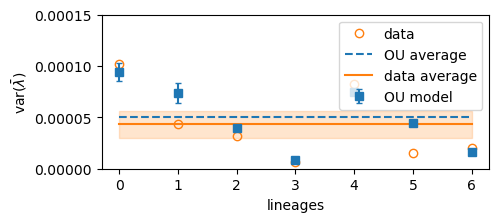

In [211]:

fig, ax= subplots(figsize=(5,2))
sims_means = combine(groupby(var_df_sims,:lineage),:gr_var => mean => :gr_var_avg).gr_var_avg
sims_std = combine(groupby(var_df_sims,:lineage),:gr_var => std => :gr_var_std).gr_var_std ./ sqrt(nreps)

ax.plot(var_df_data.gr_var,"C1o",label="data",fillstyle="none")
ax.errorbar(0:(length(lineages)-1),sims_means,yerr=sims_std,label="OU model",capsize=2,marker="s",color="C0",linestyle="none")
ax.plot(ones(length(var_data)) .* mean(sims_means),"C0--",label="OU average")
ax.plot(ones(length(var_data)) .* mean(var_data),"C1-",label="data average")
ax.fill_between(0:(length(lineages)-1),ones(length(var_data)) .* mean(var_data) .-  std(var_data)/sqrt(length(lineages)), 
ones(length(var_data)) .* mean(var_data) .+  std(var_data)/sqrt(length(lineages)),alpha=0.2,color="C1")
ax.legend(frameon=true)
ax.set_ylabel(L"${\rm var}(\bar{\lambda})$")
ax.set_xlabel("lineages")
ax.set_ylim([0,0.00015])
savefig("./../figures/OU_vs_data.pdf",bbox_inches="tight")
fig


In [146]:
var_sims

7-element Vector{Float64}:
 0.0001627816056260398
 5.151792456178446e-5
 5.073399151801475e-5
 8.239929398943102e-6
 7.723984854049312e-5
 4.355168811158745e-5
 2.3369229076075643e-5

Row,lineage,replicate,gr_var
,Float64,Float64,Float64
1,1.0,1.0,3.899e-5
2,1.0,2.0,9.14804e-5
3,1.0,3.0,0.000328138
4,1.0,4.0,8.13818e-5
5,1.0,5.0,9.62488e-5
6,1.0,6.0,6.1035e-5
7,1.0,7.0,0.000256446
8,1.0,8.0,5.15166e-5
9,1.0,9.0,0.000120995
